In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from functions import plot_formation

%matplotlib widget

In [2]:
mat_file_path = './FC_data/data.mat'
mat_data = scipy.io.loadmat(mat_file_path)

In [18]:
K = 5000 #K = int(mat_data['K'][0][0])                    # number of iterations
T = 100                                         # number of measurements                              
L = mat_data['L']                               # NxN edge weights
M = int(mat_data['M'][0][0])                    # number of edges
N = int(mat_data['N'][0][0])                    # number of agents
R = mat_data['R']                               # covariance matrix
dt = 0.1 #dt = float(mat_data['dt'][0][0])                # timestep
z0 = mat_data['z']                               # Nx2 actual positions 
z_star = mat_data['z_star']                     # Nx2 target positions
D = z_star.shape[1]                             # number of dimensions

Theorem 3.3 from the thesis explained that for a $R^D$ dimension space you need at leest $D+1$ leader agents whose position does not change.

In [19]:
def formation(add_noise=False, estimator='mean'):
    z = np.ones((N, D, K))*z0.reshape(N, D, 1)
    error = np.zeros(K)
    k = 0
    while k < K-1:
        for i in range(3, N):
            z_i = z[i, :, k]
            z_j = z[:, :, k]
            dz = z_i - z_j
            if add_noise:
                noise = np.random.multivariate_normal([0, 0], R, (N,T)).reshape(N, D, T)
                meas = dz.reshape(N, D, 1) + noise
            else:
                meas = dz.reshape(N, D, 1)            
            if estimator =='None':
                est = meas[:, :, 0]
            elif estimator == 'mean':
                est = np.mean(meas, axis=2)  # estimator 1: mean of measurements
            elif estimator == 'min':
                est = np.amin(meas, axis=2)  # estimator 2: minimum of measurements
            elif estimator == 'max':
                est = np.amax(meas, axis=2)  # estimator 3: maximum of measurements
            u = np.dot(L[i], est)
            z[i, :, k+1] = z_i + dt * u
        k += 1
    error = np.sum(np.linalg.norm(z-z_star.reshape((N,D,1)), axis=1), axis=0)
    return z, error
        

In [23]:
z_nonoise, error_nonoise = formation(0, 'None')
z_none, error_none = formation(1, 'None')
z_mean, error_mean = formation(1, 'mean')
z_min, error_min = formation('min')
z_max, error_max = formation('max')

Text(0.5, 0.98, 'Max estimator')

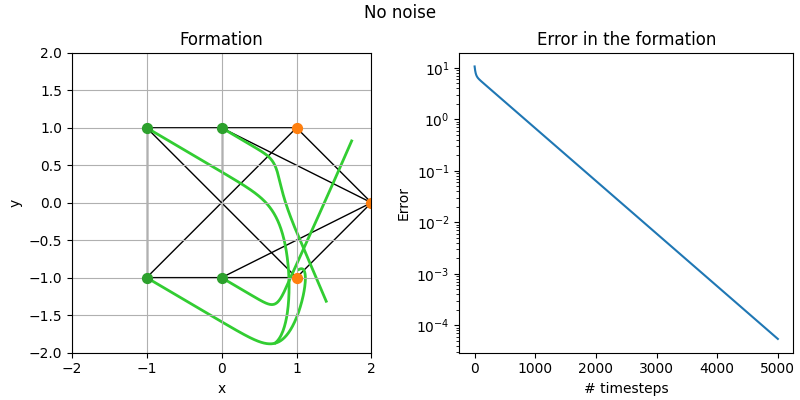

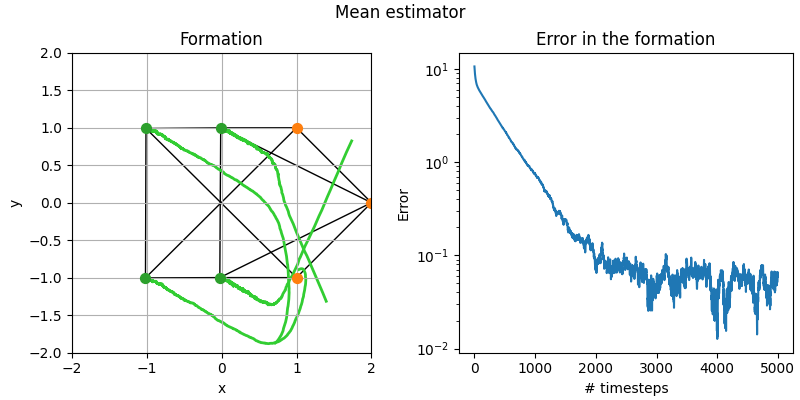

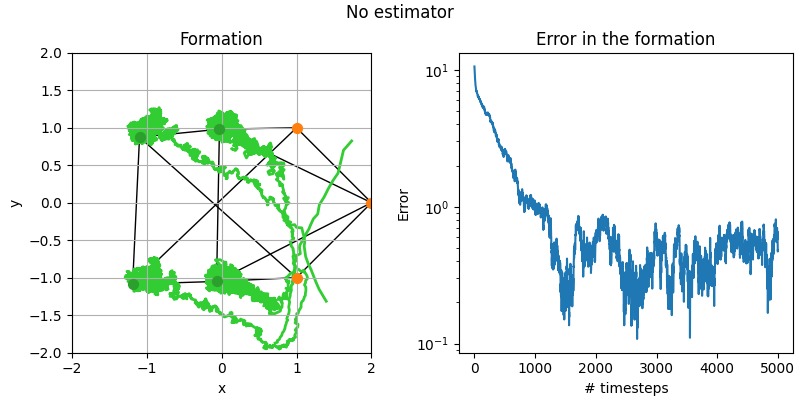

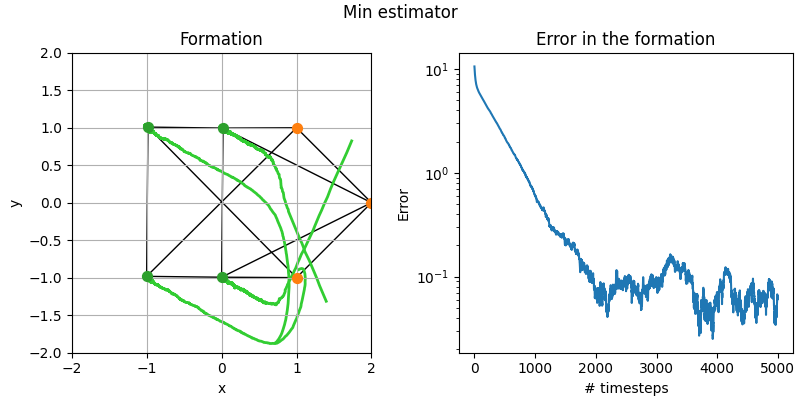

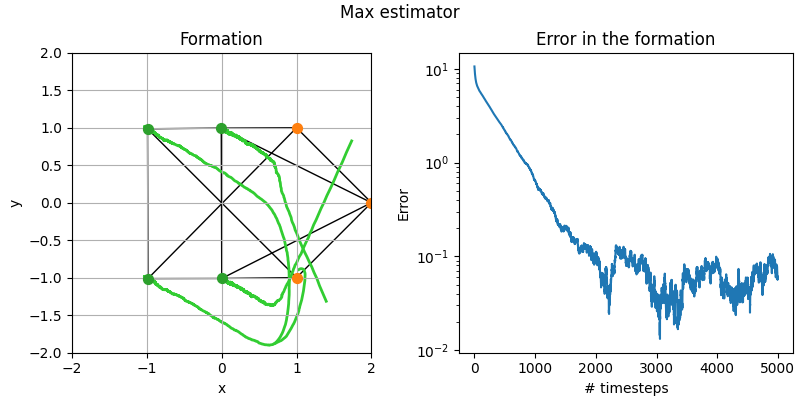

In [24]:
fig = plot_formation(z_nonoise)
fig.suptitle('No noise')
fig = plot_formation(z_mean)
fig.suptitle('Mean estimator')
fig = plot_formation(z_none)
fig.suptitle('No estimator')
fig = plot_formation(z_max)
fig.suptitle('Min estimator')
fig = plot_formation(z_min)
fig.suptitle('Max estimator')

In [35]:
def formation_error(estimator='mean'):  # implement randomized starting positions
    errors = np.zeros((10, K))
    for nr, error in enumerate(errors):
        z = np.ones((N, D, K))*z0.reshape(N, D, 1)
        k = 0
        while k < K-1:
            for i in range(3, N):
                z_i = z[i, :, k]
                z_j = z[:, :, k]
                dz = z_i - z_j
                noise = np.random.multivariate_normal([0, 0], R, (N,T)).reshape(N, D, T)
                meas = dz.reshape(N, D, 1) + noise
                if estimator == 'mean':
                    est = np.mean(meas, axis=2)  # estimator 1: mean of measurements
                elif estimator == 'min':
                    est = np.amin(meas, axis=2)  # estimator 2: minimum of measurements
                elif estimator == 'max':
                    est = np.amax(meas, axis=2)  # estimator 3: maximum of measurements
                u = np.dot(L[i], est)
                z[i, :, k+1] = z_i + dt * u
            k += 1
        errors[nr] = np.sum(np.linalg.norm(z-z_star.reshape((N,D,1)), axis=1), axis=0)
    return errors

def plot_error(error, ax):
    mean_error_mean = np.mean(error, axis=0)
    std_error_mean = np.std(error, axis=0)

    ax.semilogy(mean_error_mean)
    ax.fill_between(range(K), mean_error_mean - std_error_mean, mean_error_mean + std_error_mean, alpha=0.3)

In [36]:
mean_error = formation_error('mean')
min_error = formation_error('min')
max_error = formation_error('max')

C:\Users\wilbertr\AppData\Local\Temp\ipykernel_17680\3829624677.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


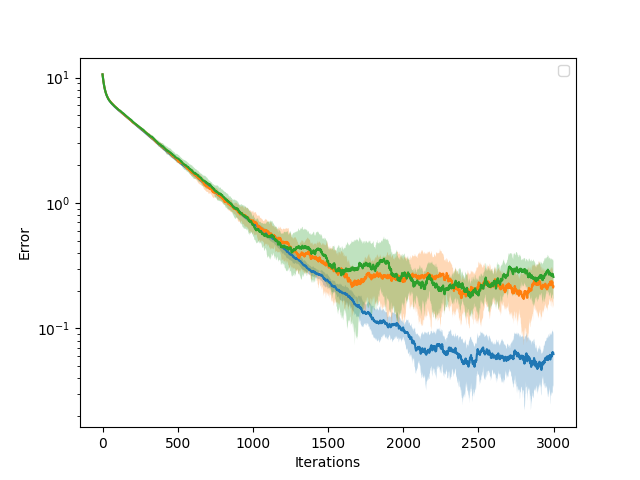

In [37]:
fig, ax = plt.subplots()
plot_error(mean_error, ax)
plot_error(min_error, ax)
plot_error(max_error, ax)
ax.legend(['mean', 'min', 'max'])
ax.set_xlabel('Iterations')
ax.set_ylabel('Error')
ax.legend()